In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

/Users/harsha_gurram/miniconda3/envs/hackUTD/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.display import display, HTML

def display_scrollable(df, rows=10):
    display(HTML(df.to_html(notebook=True, max_rows=rows, max_cols=None, border=0)))

In [3]:
pipe_df = pd.read_csv("./data/Courageous_729H-09_25-09_28.csv")

In [4]:
pipe_df.head()

,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,09/25/2024 12:00:00 am,993.002150,NaN,43.640763
1,09/25/2024 12:02:00 am,979.919175,NaN,43.473800
2,09/25/2024 12:04:00 am,976.157250,NaN,NaN
3,09/25/2024 12:06:00 am,963.743400,973.5,43.473800
4,09/25/2024 12:08:00 am,945.198300,NaN,44.332660


In [5]:
# Assume pipe_df is your DataFrame with the column "Inj Gas Meter Volume Instantaneous"
# pipe_df = pd.read_csv("your_file.csv")  # Uncomment if loading from a file
pipe_df['ds'] = pipe_df["Time"]  # Ensure the index is datetime or adjust as necessary
pipe_df['y'] = pipe_df["Inj Gas Meter Volume Instantaneous"]

# Fit a Prophet model
model = Prophet()
model.fit(pipe_df[['ds', 'y']])

# Make predictions
future = model.make_future_dataframe(periods=0)  # Predict only on existing data
forecast = model.predict(future)

# Merge predictions back into the original DataFrame
pipe_df['yhat'] = forecast['yhat']
pipe_df['yhat_lower'] = forecast['yhat_lower']
pipe_df['yhat_upper'] = forecast['yhat_upper']

# Detect anomalies
pipe_df['anomaly'] = (pipe_df['y'] < pipe_df['yhat_lower']) | (pipe_df['y'] > pipe_df['yhat_upper'])

/Users/harsha_gurram/miniconda3/envs/hackUTD/lib/python3.11/site-packages/prophet/forecaster.py:1133: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.history_dates = pd.to_datetime(pd.Series(history['ds'].unique(), name='ds')).sort_values()
/Users/harsha_gurram/miniconda3/envs/hackUTD/lib/python3.11/site-packages/prophet/forecaster.py:287: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
03:26:08 - cmdstanpy - INFO - Chain [1] start processing
03:26:08 - cmdstanpy - INFO - Chain [1] done processing


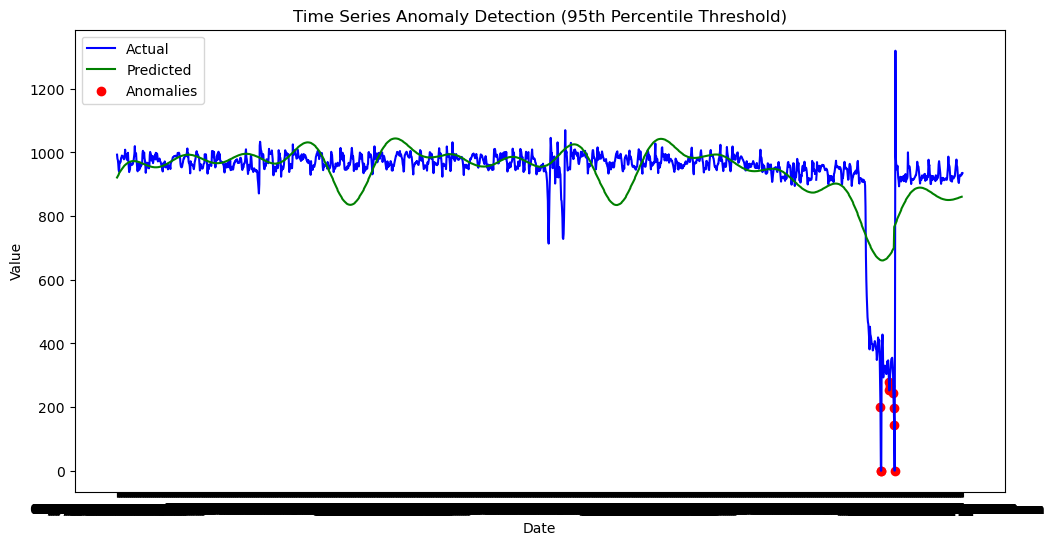

In [10]:
pipe_df['deviation'] = abs(pipe_df['y'] - pipe_df['yhat'])
threshold = pipe_df['deviation'].quantile(0.995)  # Set a threshold at the 95th percentile
pipe_df['anomaly'] = (pipe_df['deviation'] > threshold) & ((pipe_df['y'] - pipe_df['yhat']) < 0)

# Plotting the graph
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(pipe_df['ds'], pipe_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(pipe_df['ds'], pipe_df['yhat'], label='Predicted', color='green')

# Highlight anomalies
plt.scatter(pipe_df.loc[pipe_df['anomaly'], 'ds'], 
            pipe_df.loc[pipe_df['anomaly'], 'y'], 
            color='red', label='Anomalies')

# Add labels and legend
plt.title('Time Series Anomaly Detection (95th Percentile Threshold)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()